In [1]:
from typing import Callable, List, Tuple

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import numba as nb

In [2]:
%matplotlib inline
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('pdf')

### Stats

In [3]:
@nb.experimental.jitclass(
    [
        ("times", nb.types.ListType(nb.types.float64)),
        ("counts", nb.types.ListType(nb.types.int64)),
    ]
)
class TimeSeries:
    def __init__(self):
        self.times = nb.typed.List.empty_list(nb.types.float64)
        self.counts = nb.typed.List.empty_list(nb.types.int64)

    def add(self, at: np.float64) -> None:
        self.put(at, self.counts[-1] + 1 if len(self.counts) > 0 else 1)

    def put(self, at: np.float64, val: np.int64) -> None:
        self.times.append(at)
        self.counts.append(val)

    def raw(self) -> Tuple[nb.typed.List[nb.types.float64], nb.typed.List[nb.types.int64]]:
        return self.times, self.counts

### Generator

In [4]:
g = nb.jit(lambda: np.random.uniform(1, 10))

### Processor

In [5]:
p = nb.jit(lambda: np.random.poisson(4))

### Step Model

In [6]:
@nb.jit
def step_model(
    generator: Callable[[], np.float64],
    processor: Callable[[], np.float64],
    total_tasks: np.int64 = 0,
    repeat: np.float64 = 0,
    step: np.float64 = 0.001,
):
    gen_stats, proc_stats, rep_stats, queue_stats = (
        TimeSeries(),
        TimeSeries(),
        TimeSeries(),
        TimeSeries(),
    )

    processed_tasks = np.int64(0)
    t_curr = np.float64(0)
    t_gen = generator()
    t_gen_prev = t_proc = np.int64(0)
    cur_queue_len = max_queue_len = np.int64(0)
    free = True

    while processed_tasks < total_tasks:
        queue_stats.put(t_curr, cur_queue_len)

        # generator
        if t_curr > t_gen:
            gen_stats.add(t_gen)

            cur_queue_len += 1
            max_queue_len = np.maximum(max_queue_len, cur_queue_len)
            t_gen_prev = t_gen
            t_gen += generator()

        # processor
        if t_curr > t_proc:
            if cur_queue_len <= 0:
                free = True
            else:
                was_free = free
                if free:
                    free = False
                else:
                    proc_stats.add(t_proc)

                    processed_tasks += 1
                    if np.random.random() <= repeat:
                        rep_stats.add(t_proc)
                        cur_queue_len += 1
                cur_queue_len -= 1

                t_proc = t_gen_prev + processor() if was_free else t_proc + processor()

        t_curr += step

    return (
        max_queue_len,
        gen_stats.raw(),
        proc_stats.raw(),
        rep_stats.raw(),
        queue_stats.raw(),
    )

### Event Model

In [7]:
@nb.jit
def add_event(events_time, events_type, time, ttype):
    i = 0
    while i < len(events_time) and events_time[i] < time:
        i += 1
    if 0 < i < len(events_time):
        events_time.insert(i - 1, time)
        events_type.insert(i - 1, ttype)
    else:
        events_time.insert(i, time)
        events_type.insert(i, ttype)


@nb.jit
def event_model(generator_rand, processor_rand, total_tasks=0, repeat=0):
    processed_tasks = 0
    cur_queue_len = max_queue_len = 0

    events_time = nb.typed.List.empty_list(nb.types.float64)
    events_type = nb.typed.List.empty_list(nb.types.int64)
    events_time.append(generator_rand())
    events_type.append(0)

    free, process_flag = True, False
    gen_stats, proc_stats, rep_stats, queue_stats = (
        TimeSeries(),
        TimeSeries(),
        TimeSeries(),
        TimeSeries(),
    )

    while processed_tasks < total_tasks:
        event_time = events_time.pop(0)
        event_type = events_type.pop(0)

        queue_stats.put(event_time, cur_queue_len)

        # generator
        if event_type == 0:
            gen_stats.add(event_time)
            cur_queue_len += 1
            if cur_queue_len > max_queue_len:
                max_queue_len = cur_queue_len

            add_event(events_time, events_type, event_time + generator_rand(), 0)

            if free:
                process_flag = True

        # processor
        elif event_type == 1:
            proc_stats.add(event_time)
            processed_tasks += 1
            if np.random.random() < repeat:
                rep_stats.add(event_time)
                cur_queue_len += 1

            process_flag = True

        if process_flag:
            if cur_queue_len > 0:
                cur_queue_len -= 1
                add_event(events_time, events_type, event_time + processor_rand(), 1)
                free = False
            else:
                free = True
            process_flag = False

    return (
        max_queue_len,
        gen_stats.raw(),
        proc_stats.raw(),
        rep_stats.raw(),
        queue_stats.raw(),
    )

### Main

In [8]:
total_tasks = 1000
repeat_percentage = 0.1
step = 0.01

In [9]:
(
    step_model_res,
    step_gen_stats,
    step_proc_stats,
    step_rep_stats,
    step_queue_stats,
) = step_model(g, p, total_tasks, repeat_percentage, step)

print("step_model:", step_model_res)

step_model: 8


In [10]:
(
    event_model_res,
    event_gen_stats,
    event_proc_stats,
    event_rep_stats,
    event_queue_stats,
) = event_model(g, p, total_tasks, repeat_percentage)

print("event_model:", event_model_res)

event_model: 9


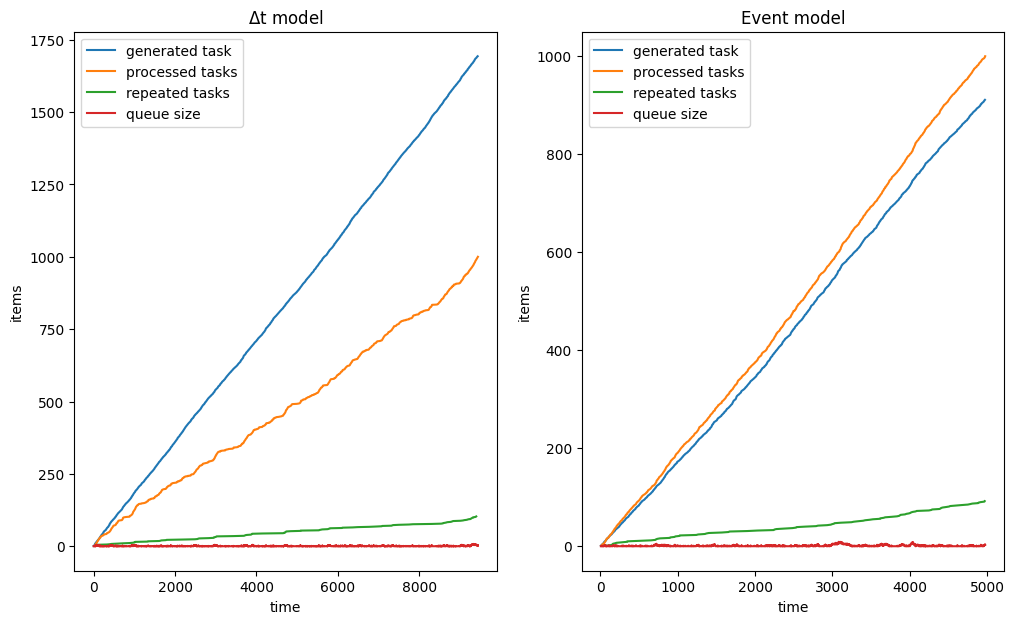

In [11]:
fig, axis = plt.subplots(1, 2, figsize=(12,7))

axis[0].set_title("$\Delta$t model")
axis[0].plot(*step_gen_stats, label="generated task")
axis[0].plot(*step_proc_stats, label="processed tasks")
axis[0].plot(*step_rep_stats, label="repeated tasks")
axis[0].plot(*step_queue_stats, label="queue size")
axis[0].set_xlabel("time")
axis[0].set_ylabel("items")
axis[0].legend()

axis[1].set_title("Event model")
axis[1].plot(*event_gen_stats, label="generated task")
axis[1].plot(*event_proc_stats, label="processed tasks")
axis[1].plot(*event_rep_stats, label="repeated tasks")
axis[1].plot(*event_queue_stats, label="queue size")
axis[1].set_xlabel("time")
axis[1].set_ylabel("items")
axis[1].legend()

plt.show()